<a href="https://colab.research.google.com/github/Yuzhou-Wang99/CS7643/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline


In [3]:
# convert MNIST imges into a tensor of 4-Dimention

transform = transforms.ToTensor()

In [4]:
# Train Data
train_data = datasets.MNIST(root = "cnn_data", train = True, download= True, transform = transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 35.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.09MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.39MB/s]


In [5]:
test_data = datasets.MNIST(root = "cnn_data", train = False, download= True, transform = transform)

In [6]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [13]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [14]:
train_loader = DataLoader(train_data, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle = False)

In [22]:
#Model class

class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)

    self.fc1 = nn.Linear(5*5*16,120)
    self.fc2 = nn.Linear(120, 60)
    self.fc3 = nn.Linear(60,10)

  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x,2,2) #2*2 kernel and stride 2

    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x,2,2) #2*2 kernel and stride 2

    # Re-view to flatten it out
    x = x.view(-1,5*5*16) #-1 so that we can vary the batch size

    #Fully connected layers
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return F.log_softmax(x,dim = 1)



In [24]:
#Create an Instance of our model

torch.manual_seed(101)
model = ConvNet()

# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [27]:
import time
start_time = time.time()

epoch = 5

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epoch):
  trn_corr = 0
  tst_corr = 0

  for b, (X_train, y_train) in enumerate(train_loader):
    b+=1 # start our batch at 1
    y_pred = model(X_train)
    loss = criterion(y_pred,y_train)

    predicted = torch.argmax(y_pred, dim=1) #torch.max(input, dim) returns a tuple of: max values and corresponding indices:
    batch_corr = (predicted == y_train).sum()
    trn_corr += batch_corr

    #update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #Print out some results
    if b%600 ==0 :
      print(f"Epoch: {i} \t Batch: {b} \t Loss: {loss.item()}")

  train_losses.append(loss)
  train_correct.append(trn_corr)

  #Test data results
  with torch.no_grad():
    for b,(X_test,y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = predicted = torch.argmax(y_val, dim=1)
      tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val,y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)



finish_time = time.time()
print(f"Training took: {(finish_time - start_time)/60} minutes !")

Epoch: 0 	 Batch: 600 	 Loss: 0.0044473567977547646
Epoch: 0 	 Batch: 1200 	 Loss: 0.11500821262598038
Epoch: 0 	 Batch: 1800 	 Loss: 0.06699031591415405
Epoch: 0 	 Batch: 2400 	 Loss: 0.44628944993019104
Epoch: 0 	 Batch: 3000 	 Loss: 0.0010046529350802302
Epoch: 0 	 Batch: 3600 	 Loss: 0.07897458970546722
Epoch: 0 	 Batch: 4200 	 Loss: 0.17728562653064728
Epoch: 0 	 Batch: 4800 	 Loss: 0.012238362804055214
Epoch: 0 	 Batch: 5400 	 Loss: 0.0012777623487636447
Epoch: 0 	 Batch: 6000 	 Loss: 0.5042980909347534
Epoch: 1 	 Batch: 600 	 Loss: 0.059484176337718964
Epoch: 1 	 Batch: 1200 	 Loss: 0.009178778156638145
Epoch: 1 	 Batch: 1800 	 Loss: 0.0018728660652413964
Epoch: 1 	 Batch: 2400 	 Loss: 0.03472519293427467
Epoch: 1 	 Batch: 3000 	 Loss: 0.0009776619262993336
Epoch: 1 	 Batch: 3600 	 Loss: 0.11465604603290558
Epoch: 1 	 Batch: 4200 	 Loss: 0.0035974658094346523
Epoch: 1 	 Batch: 4800 	 Loss: 0.0017417862545698881
Epoch: 1 	 Batch: 5400 	 Loss: 0.243601992726326
Epoch: 1 	 Batch: 6

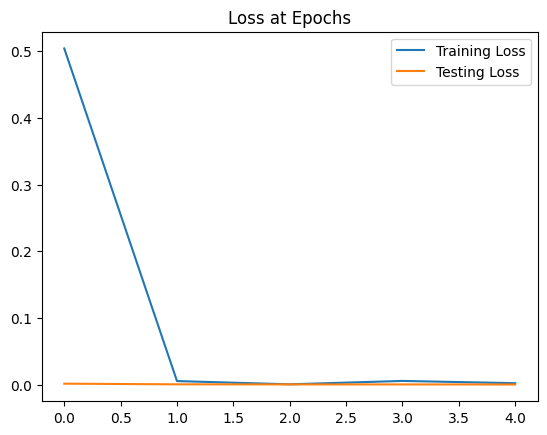

In [29]:
# Graph the loss of each epoch

train_losses = [t.detach().numpy() for t in train_losses]
train_correct = [t.detach().numpy() for t in train_correct]
plt.plot(train_losses, label = "Training Loss")
plt.plot(test_losses, label = "Testing Loss")
plt.title("Loss at Epochs")
plt.legend()
plt.show()

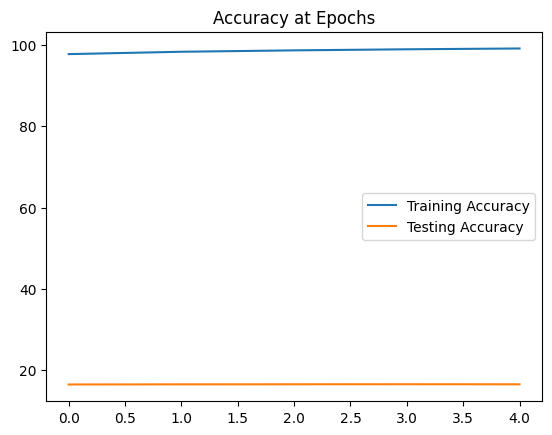

In [30]:
# graph the accuracy at the end of each epoch

plt.plot([t/600 for t in train_correct], label = "Training Accuracy")
plt.plot([t/600 for t in test_correct], label = "Testing Accuracy")
plt.title("Accuracy at Epochs")
plt.legend()
plt.show()

In [33]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
  correct =0
  for X_test,y_test in test_load_everything:
    y_pred = model(X_test)
    predicted = torch.argmax(y_pred,1)
    correct += (predicted == y_test).sum()
correct

tensor(9872)

Choose the image number you want to evaluate:34


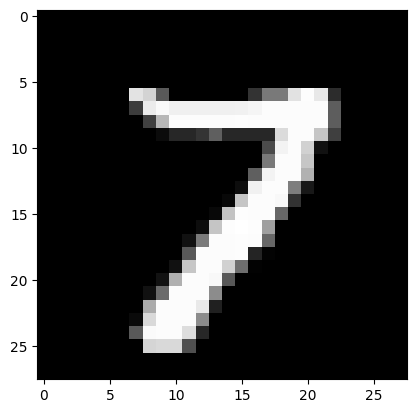

In [51]:
# Get an image
image_index = int(input("Choose the image number you want to evaluate:"))
test_image = test_data[image_index][0].reshape(28,28) #before reshape it has shape(1,28,28)
plt.imshow(test_image, cmap = "gray")

In [52]:
model.eval()
with torch.no_grad():
  pred = model(test_data[image_index][0].reshape(1,1,28,28))

print(torch.argmax(pred,1))

tensor([7])
